In [151]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# !pip install pybaseball
import pybaseball as pyb

### On-Plane Efficiency – Measures the percentage of your swing where the bat is on the swing plane. Your vertical bat angle at contact establishes the plane for that swing. Plane is a great indicator of making consistent contact and barreling balls

### “Vertical Bat Angle is the angle of the bat with respect to horizontal at the moment of impact. Vertical Bat Angle is measured in degrees and provides the location of the barrel of the bat relative to the knob of the bat at impact. Vertical Bat Angle will be zero when the barrel of the bat and the knob are parallel to the ground. Vertical Bat Angle will be negative when the barrel of the bat is below the knob of the bat at impact.”

### Vertical attack angle (VAA) is a metric that most people reading this are probably familiar with and one we talk about a lot when training athletes. VAA describes the angle between the resultant velocity vector of the sweet spot of the bat and the ground (figure 2). Zero degrees occurs when the barrel is traveling parallel to the ground. A positive attack angle occurs when the barrel is moving upward and a negative angle occurs when the barrel is moving toward the ground.

### Pitcher reports: what pitches were hit, what location was hit hard and what locations/pitches had success
### Hitter Reports: what pitches did you swing at, what pitches did you have success against


In [152]:
data = pd.read_csv('AnalyticsQuestionnaireHitData.csv')

data.head()

,Unnamed: 0,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,HomeTeamId,AwayTeamId,PitchCall,PitchType,...,VertApproachAngle,HorzApproachAngle,LaunchSpeed,LaunchAngle,LaunchSpinAxis,LaunchDirection,LaunchSpinRate,LandingPositionX,LandingPositionY,LandingPositionZ
0,1,1,1,1,L,R,115,119,called_strike,CH,...,-7.634186,1.087663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,1,1,L,R,115,119,ball,KC,...,-9.791415,3.901629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,1,1,L,R,115,119,field_out,SL,...,-5.721138,2.533320,82.429787,30.821812,204.93396,10.787098,2263.124756,104.179558,295.970184,0.030403
3,4,4,2,1,L,L,115,119,ball,SI,...,-5.594223,-0.382425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,2,1,L,L,115,119,swinging_strike,KC,...,-9.407112,2.861959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
data.columns

Index(['Unnamed: 0', 'PitchId', 'BatterId', 'PitcherId', 'PitcherHand',
       'BatterSide', 'HomeTeamId', 'AwayTeamId', 'PitchCall', 'PitchType',
       'ReleaseSpeed', 'PlateX', 'TrajectoryLocationY', 'PlateZ',
       'StrikeZoneTop', 'StrikeZoneBottom', 'Balls', 'Strikes',
       'VerticalBreak', 'InducedVerticalBreak', 'HorzBreak',
       'VertApproachAngle', 'HorzApproachAngle', 'LaunchSpeed', 'LaunchAngle',
       'LaunchSpinAxis', 'LaunchDirection', 'LaunchSpinRate',
       'LandingPositionX', 'LandingPositionY', 'LandingPositionZ'],
      dtype='object')

In [154]:
# remove columns that are unnecesary. Since this data is all from the same game, the home and away ids will be
# constant for the whole dataframe
data.drop(columns = ['Unnamed: 0','HomeTeamId','AwayTeamId'],inplace = True)

In [155]:
# change InducedVerticalBreak and HorzBreak to inches instead of feet
data.InducedVerticalBreak  = data.InducedVerticalBreak*12
data.HorzBreak  = data.HorzBreak*12

# Change Plate X and Z to inches as well 
data.PlateX  = data.PlateX*12
data.PlateZ  = data.PlateZ*12

In [156]:
data.PitchCall.unique()

array(['called_strike', 'ball', 'field_out', 'swinging_strike', 'single',
       'pickoff_attempt_1b', 'walk', 'foul', 'blocked_ball', 'strikeout',
       'double', 'foul_bunt', 'stolen_base_3b', 'foul_tip',
       'grounded_into_double_play', 'home_run', 'force_out',
       'stolen_base_2b', 'wild_pitch'], dtype=object)

In [157]:
data[data.PitchCall == 'stolen_base_2b']

,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,TrajectoryLocationY,...,VertApproachAngle,HorzApproachAngle,LaunchSpeed,LaunchAngle,LaunchSpinAxis,LaunchDirection,LaunchSpinRate,LandingPositionX,LandingPositionY,LandingPositionZ
255,256,5,6,R,L,stolen_base_2b,CU,80.450233,-5.64341,1.416667,...,-9.383094,-1.334879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
# remove any pickoff_attempts because they dont give any valuable information for this analysis
# also plays that result in a stolen base do not have information about if the pitch was a ball or strike
data = data[~data.PitchCall.isin(['pickoff_attempt_1b','stolen_base_2b','stolen_base_3b'])]
data = data.reset_index()

In [159]:
# round some variables
data.ReleaseSpeed = round(data.ReleaseSpeed,1)
data.LaunchSpeed = round(data.LaunchSpeed,2)
data.LaunchAngle = round(data.LaunchAngle,2)

In [160]:
# fill launch speed and launch angle variables with 0 and 'None' respectively
data.LaunchSpeed = data.LaunchSpeed.fillna(0)
data.LaunchAngle = data.LaunchAngle.fillna('None')

In [161]:
data.LaunchSpeed.describe()

count    342.000000
mean      27.472047
std       39.200215
min        0.000000
25%        0.000000
50%        0.000000
75%       71.195000
max      108.270000
Name: LaunchSpeed, dtype: float64

In [162]:
data[data.LaunchSpeed>98]

,index,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,...,VertApproachAngle,HorzApproachAngle,LaunchSpeed,LaunchAngle,LaunchSpinAxis,LaunchDirection,LaunchSpinRate,LandingPositionX,LandingPositionY,LandingPositionZ
5,5,6,2,1,L,L,single,SI,90.9,8.830505,...,-6.026230,0.089518,104.83,5.19,298.274048,33.187984,3698.538086,63.701733,89.854118,-0.002012
37,38,39,9,1,L,R,double,KC,78.3,-3.441171,...,-8.896836,2.181962,106.03,15.41,95.409523,-30.851000,7708.296875,-155.963638,205.806427,0.008609
66,70,71,14,2,R,R,single,CH,84.8,3.795422,...,-7.014757,-2.936115,102.25,2.95,270.231201,6.944455,664.811951,13.978411,85.844765,0.007282
70,74,75,15,2,R,L,double,CH,87.0,-6.360604,...,-6.222175,-1.903892,104.29,8.24,228.509171,11.528565,1502.839355,48.536957,197.780045,0.000990
156,162,163,2,1,L,L,single,SI,92.0,1.526592,...,-6.573693,0.810912,102.15,11.85,143.365173,5.639507,342.933014,17.708044,224.467789,0.012932
162,168,169,5,1,L,L,foul,SI,93.1,11.769326,...,-6.295873,-0.200350,99.43,-28.62,180.000000,66.939331,4442.365723,4.186556,2.766424,-0.004226
176,182,183,6,2,R,L,home_run,FC,90.4,4.641479,...,-5.960848,-4.346654,100.19,36.35,194.406784,27.789267,3244.253906,247.518646,330.531555,0.019564
197,203,204,11,1,L,L,field_out,SI,92.6,8.445071,...,-6.418814,0.132153,108.27,-16.8,180.000000,37.157494,3338.793457,4.333249,5.356784,-0.007068
245,257,258,5,6,R,L,field_out,SL,90.4,-1.882032,...,-7.118275,-1.186989,98.41,41.09,162.377136,-13.430793,3811.359375,-168.829163,324.119629,0.019872
252,264,265,9,6,R,R,double,SI,94.5,5.843668,...,-5.461021,-0.839589,104.24,7.13,258.368927,11.126913,1108.692871,40.330017,161.953186,-0.001437


In [163]:
### Barrel variable 
# based on this, https://www.mlb.com/glossary/statcast/barrel, lets also create a flag for barrel rate
def barrel(row):
    if pd.isna(row['LaunchSpeed']):
        return 'Other'
    exit_velo = math.floor(row['LaunchSpeed']/1)
    
    if(exit_velo<98):
        return 'Other'
    
    barrel_range = exit_velo - 98
    range_upper = 30+barrel_range
    range_lower = 26-barrel_range
    
    if((row['LaunchAngle']>range_lower) & (row['LaunchAngle']<range_upper)):
        return "Barrel"
    else:
        return 'Other'

data['barrel'] = data.apply(barrel,axis=1)
data.barrel.value_counts()

barrel
Other     341
Barrel      1
Name: count, dtype: int64

In [164]:
data.PitchCall.unique()

array(['called_strike', 'ball', 'field_out', 'swinging_strike', 'single',
       'walk', 'foul', 'blocked_ball', 'strikeout', 'double', 'foul_bunt',
       'foul_tip', 'grounded_into_double_play', 'home_run', 'force_out',
       'wild_pitch'], dtype=object)

### Check if pitch resulted in an out. Returns 1 for any kind of out and 2 for a double play

In [165]:
def get_outs(outcome):
    if outcome in ['field_out','strikeout','force_out']:
        return 1
    if outcome == 'grounded_into_double_play':
        return 2
    else: 
        return 0
    
data['Outs_Generated'] = data['PitchCall'].apply(lambda x: get_outs(x))

### Check if pitch resulted in a hit, out, walk, or not in-play


In [166]:
def get_result(outcome):
    if outcome in ['field_out','strikeout','force_out','grounded_into_double_play']:
        return 'Out'
    if outcome in ['single','double','home_run']:
        return 'Hit'
    if outcome == 'walk':
        return 'Walk'
    else: 
        return 'Not In-Play'
    
data['PitchResult'] = data['PitchCall'].apply(lambda x: get_result(x))

### Get slugging vales for each ball inplay. Single is 1, double is 2, triple is 3, home_run is 4, and everything else is 0

In [167]:
def get_slg(outcome):
    if outcome == 'single':
        return 1
    if outcome == 'double':
        return 2
    if outcome == 'triple':
        return 3
    if outcome == 'home_run':
        return 4
    else: 
        return 0
data['slg'] = data['PitchCall'].apply(lambda x: get_slg(x))

### Get the amount of outs in the curent inning


In [168]:
inning_outs = [0] * len(data)
total_outs = 0

for i in range(len(data)):
    total_outs += data.loc[i,'Outs_Generated']
    
    # if the total number of outs is greater than 3 (caused by double play) set the number of outs to 3
    # and reset the number of outs 
    if total_outs >= 3:
        inning_outs[i] = 3
        total_outs = 0 
    else: 
        inning_outs[i] = total_outs
     
data['inning_outs'] = inning_outs

data.head()

,index,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,...,LaunchDirection,LaunchSpinRate,LandingPositionX,LandingPositionY,LandingPositionZ,barrel,Outs_Generated,PitchResult,slg,inning_outs
0,0,1,1,1,L,R,called_strike,CH,83.0,0.007897,...,NaN,NaN,NaN,NaN,NaN,Other,0,Not In-Play,0,0
1,1,2,1,1,L,R,ball,KC,79.0,-14.971869,...,NaN,NaN,NaN,NaN,NaN,Other,0,Not In-Play,0,0
2,2,3,1,1,L,R,field_out,SL,87.3,-3.249832,...,10.787098,2263.124756,104.179558,295.970184,0.030403,Other,1,Out,0,1
3,3,4,2,1,L,L,ball,SI,91.5,13.638619,...,NaN,NaN,NaN,NaN,NaN,Other,0,Not In-Play,0,1
4,4,5,2,1,L,L,swinging_strike,KC,80.2,-6.826855,...,NaN,NaN,NaN,NaN,NaN,Other,0,Not In-Play,0,1


### Get the Inning along with if it is the top or bottom of the inning

In [169]:
inning = [0] * len(data)
Inning_Top_Bottom = [0] * len(data)

top_bottom = ['Top','Bottom']
inning_counter = 1
temp_counter = 0

for i in range(len(data)):
    inning[i] = inning_counter
    Inning_Top_Bottom[i] = top_bottom[temp_counter]
    
    if(data.loc[i,'inning_outs']==3):
        temp_counter+=1
        temp_counter %= 2
        if(temp_counter==0):
            inning_counter+=1
        
data['Inning'] = inning
data['Inning_Top_Bottom'] = Inning_Top_Bottom

In [170]:
data.tail(30)

,index,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,...,LandingPositionX,LandingPositionY,LandingPositionZ,barrel,Outs_Generated,PitchResult,slg,inning_outs,Inning,Inning_Top_Bottom
312,325,326,24,10,R,R,strikeout,FC,93.2,0.586985,...,NaN,NaN,NaN,Other,1,Out,0,1,9,Bottom
313,328,329,6,10,R,L,ball,FC,92.4,-0.759034,...,NaN,NaN,NaN,Other,0,Not In-Play,0,1,9,Bottom
314,329,330,6,10,R,L,field_out,FC,92.9,1.902753,...,0.635938,4.026285,0.020310,Other,1,Out,0,2,9,Bottom
315,330,331,7,10,R,R,foul,FC,93.5,-7.815051,...,96.020866,-171.716339,0.012830,Other,0,Not In-Play,0,2,9,Bottom
316,331,332,7,10,R,R,ball,FC,94.5,-12.692430,...,NaN,NaN,NaN,Other,0,Not In-Play,0,2,9,Bottom
317,332,333,7,10,R,R,ball,FC,92.4,-6.278918,...,NaN,NaN,NaN,Other,0,Not In-Play,0,2,9,Bottom
318,333,334,7,10,R,R,foul,FC,93.3,2.049778,...,NaN,NaN,NaN,Other,0,Not In-Play,0,2,9,Bottom
319,334,335,7,10,R,R,strikeout,SL,83.4,-2.785143,...,NaN,NaN,NaN,Other,1,Out,0,3,9,Bottom
320,335,336,5,11,L,L,home_run,SL,79.9,2.594332,...,24.206671,438.914459,-0.018666,Barrel,0,Hit,4,0,10,Top
321,336,337,9,11,L,R,field_out,FF,91.7,-8.528617,...,10.444743,275.208954,-0.033853,Other,1,Out,0,1,10,Top


### Create a counter for each player that shows which at-bat each pitch corresponds to

In [171]:
at_bat = [0] * len(data)

# create flag that tells us when the end of the AB is 

AB_dictionary = {}
prev_batter_id = 0

for i in range(len(data)):
    current_batter = data.loc[i,'BatterId']
    
    # if the current batter is different than the previous batter, a new at bat has started
    if(current_batter!=prev_batter_id):
        
        # we then increment the amount of at bats the player has had.
        # if this is their first at-bat, set the value in the dictionary to 1, otherwise add 1 to it
        if(current_batter not in AB_dictionary):
            AB_dictionary[current_batter] = 1
        else:
            AB_dictionary[current_batter] += 1
            
    # set the at_bat number to the new 
    at_bat[i] = AB_dictionary[current_batter] 
    prev_batter_id = current_batter
    
data['At_Bat_Num'] = at_bat
data[data.BatterId==2]

,index,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,...,LandingPositionY,LandingPositionZ,barrel,Outs_Generated,PitchResult,slg,inning_outs,Inning,Inning_Top_Bottom,At_Bat_Num
3,3,4,2,1,L,L,ball,SI,91.5,13.638619,...,NaN,NaN,Other,0,Not In-Play,0,1,1,Top,1
4,4,5,2,1,L,L,swinging_strike,KC,80.2,-6.826855,...,NaN,NaN,Other,0,Not In-Play,0,1,1,Top,1
5,5,6,2,1,L,L,single,SI,90.9,8.830505,...,89.854118,-0.002012,Other,0,Hit,1,1,1,Top,1
55,58,59,2,1,L,L,ball,KC,81.4,7.228596,...,NaN,NaN,Other,0,Not In-Play,0,2,2,Top,2
56,59,60,2,1,L,L,single,KC,80.2,13.924567,...,173.702713,-0.015890,Other,0,Hit,1,2,2,Top,2
154,160,161,2,1,L,L,ball,SI,89.9,1.158359,...,NaN,NaN,Other,0,Not In-Play,0,0,5,Top,3
155,161,162,2,1,L,L,foul,SI,90.7,8.852145,...,2.271510,0.035890,Other,0,Not In-Play,0,0,5,Top,3
156,162,163,2,1,L,L,single,SI,92.0,1.526592,...,224.467789,0.012932,Other,0,Hit,1,0,5,Top,3
221,227,228,2,4,R,L,field_out,CH,90.3,-5.646407,...,388.388367,-0.006906,Other,1,Out,0,3,7,Top,4
294,306,307,2,9,R,L,ball,CH,89.4,9.875959,...,NaN,NaN,Other,0,Not In-Play,0,2,9,Top,5


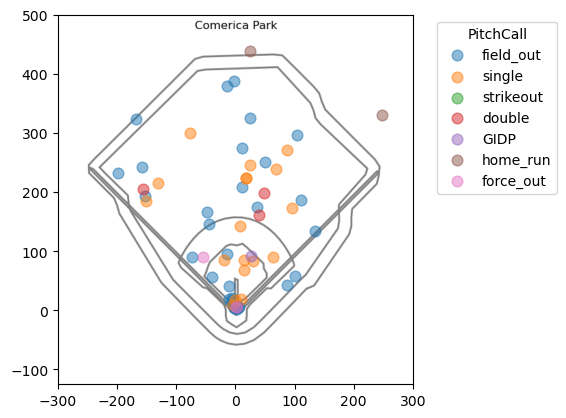

<Axes: title={'center': 'Comerica Park'}>

In [176]:
# code inspiration found from pybaseballs documentation: https://github.com/jldbc/pybaseball/blob/master/pybaseball/plotting.py
# only takes in data where ball is put inplay
def spray_chart(inplay_data,indiv_player):
    # pull stadium plot to overlay hits on
    stadium_img = mpimg.imread('tigers_stadium.png')

    fig, ax = plt.subplots()
    ax.imshow(stadium_img, extent=[-300, 300, -125, 500])  # Adjust extent to fit your data scale

    colorby = 'PitchCall'
    color_label = 'PitchCall'
    legend_title = 'PitchCall'
    size = 60
    
    scatters = []
    for color in inplay_data[color_label].unique():
        color_sub_data = inplay_data[inplay_data[color_label] == color]
        scatters.append(ax.scatter(
            color_sub_data["LandingPositionX"], color_sub_data['LandingPositionY'], size, label=color, alpha=0.5
        ))
        if(indiv_player):
            # Iterate over the rows of color_sub_data to annotate each point
            for _, row in color_sub_data.iterrows():
                ax.annotate(str(row['At_Bat_Num']),  # Convert 'at-bat' to string if it's not already
                            (row["LandingPositionX"], row['LandingPositionY'])
                            )
        
    plt.legend(handles=scatters, title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.draw()

    plt.show()

    return base

test = data[((data.PitchResult != 'Walk') & (data.PitchResult != 'Not In-Play'))]

spray_chart(test,0)

In [174]:
# Change name of 'grounded_into_double_play' call
data.PitchCall = data.PitchCall.apply(lambda x: 'GIDP' if x=='grounded_into_double_play' else x)

In [175]:
data.to_csv('data_new.csv',mode = 'w+')

In [24]:
data_contact = data[data.LaunchAngle.notna()]
data_inPlay = data_contact[data_contact.PitchCall!='foul']
data_inPlay.columns

Index(['index', 'PitchId', 'BatterId', 'PitcherId', 'PitcherHand',
       'BatterSide', 'PitchCall', 'PitchType', 'ReleaseSpeed', 'PlateX',
       'TrajectoryLocationY', 'PlateZ', 'StrikeZoneTop', 'StrikeZoneBottom',
       'Balls', 'Strikes', 'VerticalBreak', 'InducedVerticalBreak',
       'HorzBreak', 'VertApproachAngle', 'HorzApproachAngle', 'LaunchSpeed',
       'LaunchAngle', 'LaunchSpinAxis', 'LaunchDirection', 'LaunchSpinRate',
       'LandingPositionX', 'LandingPositionY', 'LandingPositionZ', 'barrel',
       'Outs_Generated', 'PitchResult', 'slg', 'inning_outs', 'Inning',
       'Inning_Top_Bottom', 'At_Bat_Num'],
      dtype='object')

In [25]:
def outcome_groupings(outcome):
    if outcome in ['field_out','grounded_into_double_play','force_out']:
        return 'in_play_out'
    elif outcome in ['single','double']:
        return 'hit'
    elif outcome in ['called_strike','swinging_strike','foul_tip','foul']:
        return 'strike'
    elif outcome in ['walk','ball','wild_pitch']:
        return 'ball'
    elif outcome == 'home_run':
        return 'home_run'


# For a hitter, I would like to know, if a pitch was a ball, if it was barrelled, if it was a ground ball, or if it was a fly ball'

In [26]:
# Create dataframes that contain info for pitchers and hitters 
pitcher_dfs = []
for pitcher in data.PitcherId.unique():
    new_df = data[data.PitcherId==pitcher]
    pitcher_dfs.append(new_df)

hitter_dfs = []
for hitter in data.BatterId.unique():
    new_df = data[data.BatterId==hitter]
    hitter_dfs.append(new_df)